In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [20]:
df = pd.read_csv("Thrissur_Featured_Optimized.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)


In [21]:
TARGET = 'target_aqi_next_day'
drop_cols = [
    'datetime', 'date', 'time', 'location_id',
    'city',
    TARGET
]

In [22]:
X = df.drop(columns=drop_cols)
y = df[TARGET]

In [23]:
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


In [24]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
y_pred = rf_model.predict(X_test)


In [26]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")


MAE  : 6.33
RMSE : 10.53
R²   : 0.342


In [27]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importance.head(15))


             feature  importance
38   aqi_rollmean_24    0.650075
42  pm10_rollmean_24    0.051580
41   pm10_rollmean_6    0.019598
33         o3_lag_24    0.019075
17             month    0.016616
10               so2    0.014166
32          o3_lag_6    0.012977
4                no2    0.012830
40  pm25_rollmean_24    0.011687
28         no2_lag_1    0.010272
30        no2_lag_24    0.010204
29         no2_lag_6    0.010103
37    aqi_rollmean_6    0.009982
9   relativehumidity    0.009728
15              hour    0.009311


In [28]:
baseline_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": X_test["aqi_lag_24"]
}).dropna()

baseline_mae = mean_absolute_error(
    baseline_df["y_true"],
    baseline_df["y_pred"]
)

print(f"Baseline MAE (AQI lag 24): {baseline_mae:.2f}")

Baseline MAE (AQI lag 24): 6.20


In [35]:
cities = df['city'].unique()


df = pd.read_csv("kerala.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)
TARGET = 'target_aqi_next_day'
drop_cols = [
    'datetime', 'date', 'time', 'location_id','location',
    'city',
    TARGET
]

C:\Users\Fahad\AppData\Local\Temp\ipykernel_8680\1349653257.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("kerala.csv")


In [36]:
city_results = {}

for city in cities:
    print(f"\nTraining model for city: {city}")
    
    city_df = df[df['city'] == city].copy()
    city_df = city_df.sort_values('datetime')
    
    X = city_df.drop(columns=drop_cols)
    y = city_df[TARGET]
    
    split_idx = int(len(city_df) * 0.8)
    
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    city_results[city] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }
    
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")


Training model for city: Ernakulam
MAE: 27.60, RMSE: 42.74, R2: -0.092

Training model for city: kariavattom
MAE: 73.09, RMSE: 103.87, R2: -0.693

Training model for city: Thrissur
MAE: 6.33, RMSE: 10.53, R2: 0.342

Training model for city: Kannur
MAE: 15.62, RMSE: 25.58, R2: -1.230

Training model for city: Kollam
MAE: 153.79, RMSE: 437.40, R2: -0.102

Training model for city: Trivandrum
MAE: 20.59, RMSE: 26.48, R2: -0.341


In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv("kerala.csv", low_memory=False)

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

print("Initial shape:", df.shape)


Initial shape: (128230, 50)


In [3]:
df = df.dropna(subset=['target_aqi_next_day'])
print("After dropping missing target:", df.shape)


After dropping missing target: (128230, 50)


In [4]:
for col in ['aqi', 'pm25', 'pm10']:
    if col in df.columns:
        low = df[col].quantile(0.01)
        high = df[col].quantile(0.99)
        df[col] = df[col].clip(low, high)


In [5]:
TARGET = 'target_aqi_next_day'


In [6]:
FEATURES = [
    # AQI temporal behavior
    'aqi_lag_1', 'aqi_lag_6', 'aqi_lag_24',
    'aqi_rollmean_6', 'aqi_rollmean_24',

    # PM features
    'pm25_lag_1', 'pm25_rollmean_24',
    'pm10_lag_1', 'pm10_rollmean_24',

    # Weather
    'temperature', 'relativehumidity', 'wind_speed',

    # Time
    'hour', 'dayofweek', 'month', 'is_weekend'
]


In [7]:
df = df.dropna(subset=FEATURES + [TARGET])
print("After feature NaN drop:", df.shape)


After feature NaN drop: (38375, 50)


In [8]:
X = df[FEATURES]
y = df[TARGET]


In [9]:
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)


Train size: (30700, 16)
Test size : (7675, 16)


In [10]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=14,              # shallower trees
    min_samples_leaf=10,       # smoothing
    min_samples_split=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)


Training Random Forest...


,n_estimators,500
,criterion,'squared_error'
,max_depth,14
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
y_pred = rf_model.predict(X_test)


In [12]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Random Forest Performance")
print("-----------------------------")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")



📊 Random Forest Performance
-----------------------------
MAE  : 32.50
RMSE : 51.40
R²   : 0.276


In [13]:
df = pd.read_csv("kerala.csv", low_memory=False)

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

# Drop rows where target is missing
TARGET = 'target_aqi_next_day'
df = df.dropna(subset=[TARGET])

print("Dataset shape:", df.shape)


Dataset shape: (128230, 50)


In [14]:
FEATURES = [
    'aqi', 'pm25', 'pm10', 'no2', 'o3',
    'temperature', 'relativehumidity', 'wind_speed',
    'hour', 'dayofweek', 'month', 'is_weekend'
]


In [16]:
FEATURES = [
    'aqi', 'pm25', 'pm10', 'no2', 'o3',
    'temperature', 'relativehumidity', 'wind_speed',
    'hour', 'dayofweek', 'month', 'is_weekend'
]

df[FEATURES] = (
    df.groupby('city')[FEATURES]
      .transform(lambda x: x.ffill().bfill())
)
# Drop rows still missing (very few)
df = df.dropna(subset=FEATURES + [TARGET])

print("After cleaning:", df.shape)


After cleaning: (128230, 50)


In [17]:
print(df[FEATURES].isna().sum())
print(df[TARGET].isna().sum())


aqi                 0
pm25                0
pm10                0
no2                 0
o3                  0
temperature         0
relativehumidity    0
wind_speed          0
hour                0
dayofweek           0
month               0
is_weekend          0
dtype: int64
0


In [18]:
X = df[FEATURES]
y = df[TARGET]


In [19]:
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)


Train size: (102584, 12)
Test size : (25646, 12)


In [20]:
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,              # shallower trees
    min_samples_leaf=15,       # smoothing
    min_samples_split=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)


Training Random Forest...


,n_estimators,400
,criterion,'squared_error'
,max_depth,12
,min_samples_split,20
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
y_pred = rf_model.predict(X_test)


In [22]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Performance (No Lag Features)")
print("------------------------------------")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")



📊 Model Performance (No Lag Features)
------------------------------------
MAE  : 45.45
RMSE : 171.76
R²   : 0.001


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Load the clean data
df = pd.read_csv('kerala_aqi_training_ready.csv')

# 2. Select Features (X) and Target (y)
# We use lags, weather, and time as features
features = ['hour', 'day_of_week', 'month', 'aqi_lag_1', 'aqi_lag_2', 'temperature', 'relativehumidity']
# Add city dummy variables (one-hot encoding)
df_model = pd.get_dummies(df, columns=['city'])
city_cols = [col for col in df_model.columns if 'city_' in col]
X = df_model[features + city_cols]
y = df_model['target_next_hour_aqi']

# 3. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate
y_pred = model.predict(X_test)
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

Mean Absolute Error (MAE): 8.95
RMSE: 23.38
R2 Score: 0.69


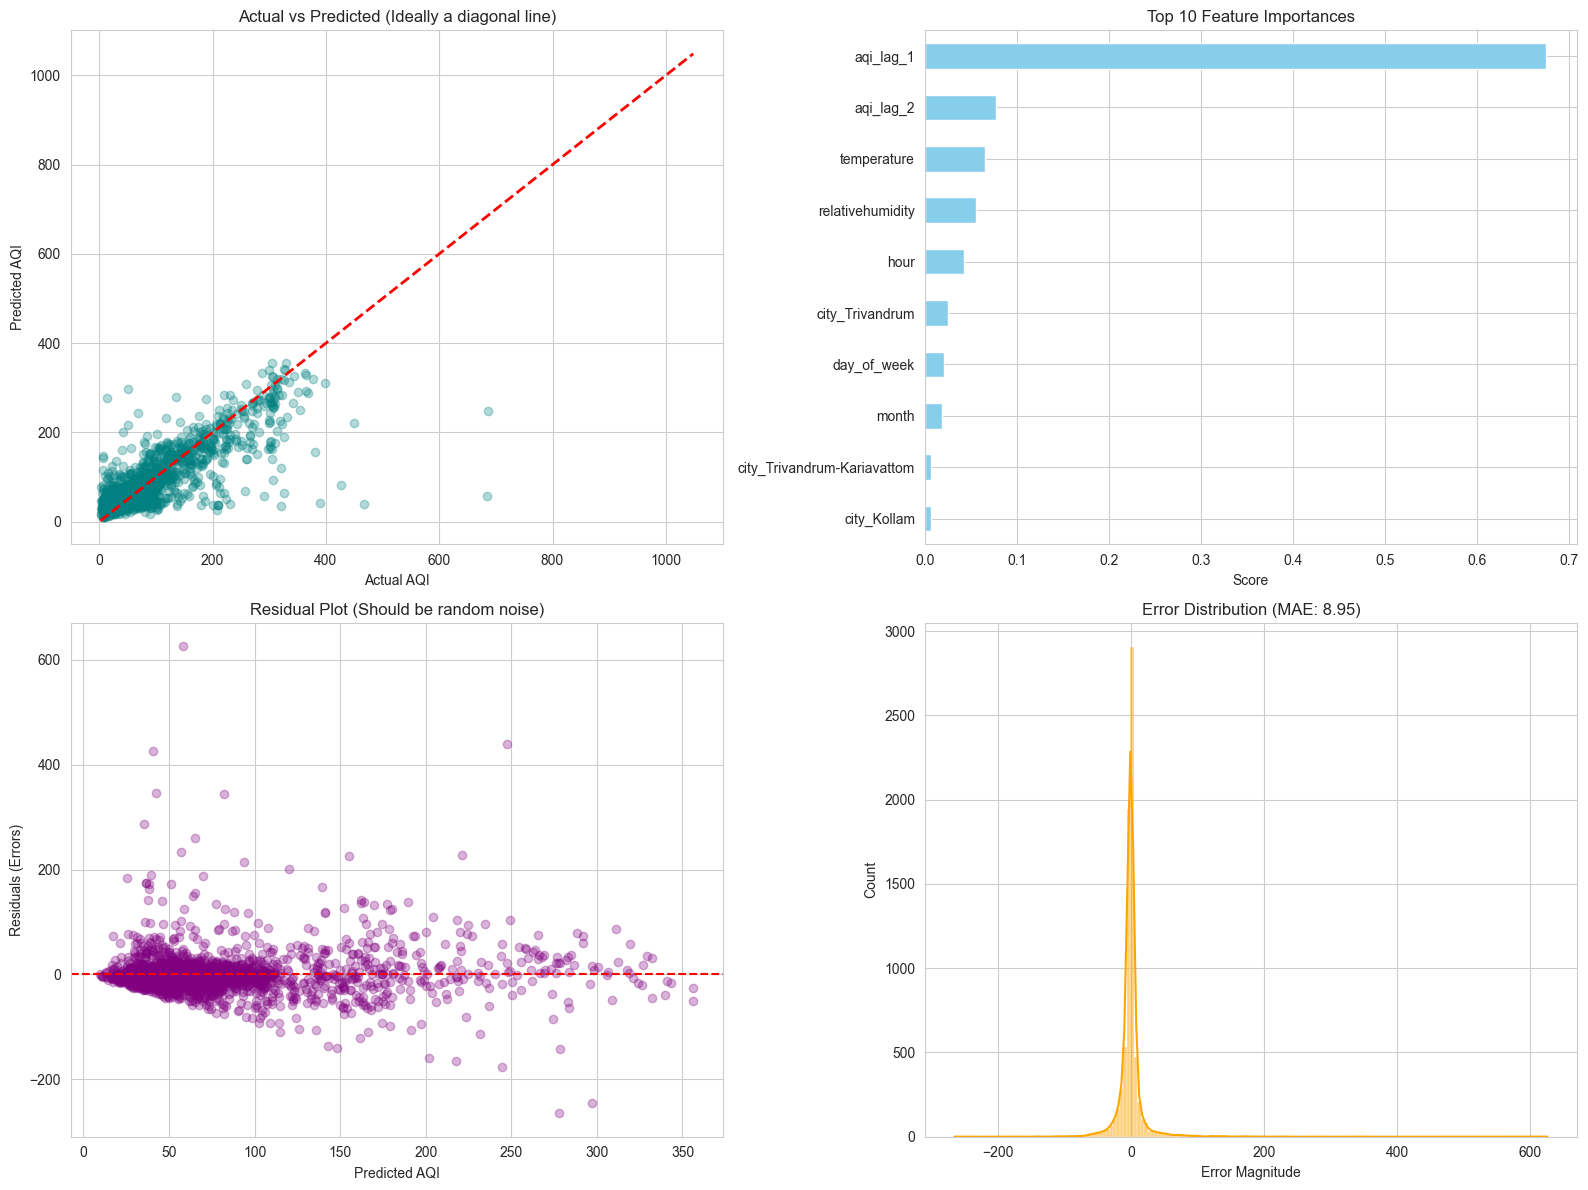

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. LOAD AND PREPARE DATA
df = pd.read_csv('kerala_aqi_training_ready.csv')
df_model = pd.get_dummies(df, columns=['city'])

features = ['hour', 'day_of_week', 'month', 'aqi_lag_1', 'aqi_lag_2', 'temperature', 'relativehumidity']
city_cols = [col for col in df_model.columns if 'city_' in col]
X = df_model[features + city_cols]
y = df_model['target_next_hour_aqi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. TRAIN MODEL
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_test - y_pred

# 3. VISUALIZATION
plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")

# Plot 1: Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted (Ideally a diagonal line)')

# Plot 2: Feature Importance
plt.subplot(2, 2, 2)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
importances.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Feature Importances')
plt.xlabel('Score')

# Plot 3: Residual Plot (Error vs Prediction)
plt.subplot(2, 2, 3)
plt.scatter(y_pred, residuals, alpha=0.3, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals (Errors)')
plt.title('Residual Plot (Should be random noise)')

# Plot 4: Error Distribution
plt.subplot(2, 2, 4)
sns.histplot(residuals, kde=True, color='orange')
plt.title(f'Error Distribution (MAE: {mean_absolute_error(y_test, y_pred):.2f})')
plt.xlabel('Error Magnitude')

plt.tight_layout()
plt.show()